In [3]:
import torch
import matplotlib.pyplot as plt
import ESN
import time
import numpy as np

torch.set_default_device("cuda:0")
torch.set_default_dtype(torch.double)
# Parameters
Two,Ttrain = 5000,100000
N = 100
C = 0.98
dim =10

N_d = int(N * dim)
maxtau = int(N_d * 1.2)



torch.manual_seed(0)
alphas = torch.tensor([1/2,1,1,1,2,2,2,2,5,10])
betas = torch.tensor([1/2,1,2,5,2,5,10,5,10,10])
m = torch.distributions.Beta(alphas,betas)



In [4]:


u_asym = m.rsample((Two + Ttrain,)).T
means = torch.mean(u_asym,dim=1).unsqueeze(1)
#u_asym = torch.normal(0,0.1,(dim, Two + Ttrain))
u_sym = u_asym - means

dim = u_asym.shape[0]
esn = ESN.ESN_mult(N_d, uC=C, dim=dim,idWin = True)
Xwo = esn.run_washout(u_sym, Two, actf="identity")
#mfs = ESN.MCwithPI_general(u_sym, Xwo, maxtau)
#mfs = ESN.MCwithPI_general_with_surrogate(u_sym, Xwo, maxtau,sur_samples=50)
mfs = ESN.MC_cSVD_old(u_sym, Xwo, maxtau)

totMC = torch.sum(mfs)

[0.12529139 0.083125   0.05545869 0.01972884 0.0498294  0.02548799
 0.01053772 0.02546923 0.01380205 0.01192176]
[300.58334416 198.85679826 129.57190438  47.48906402 116.81885311
  61.92253181  25.41525451  59.54127345  33.09151987  26.83609207]


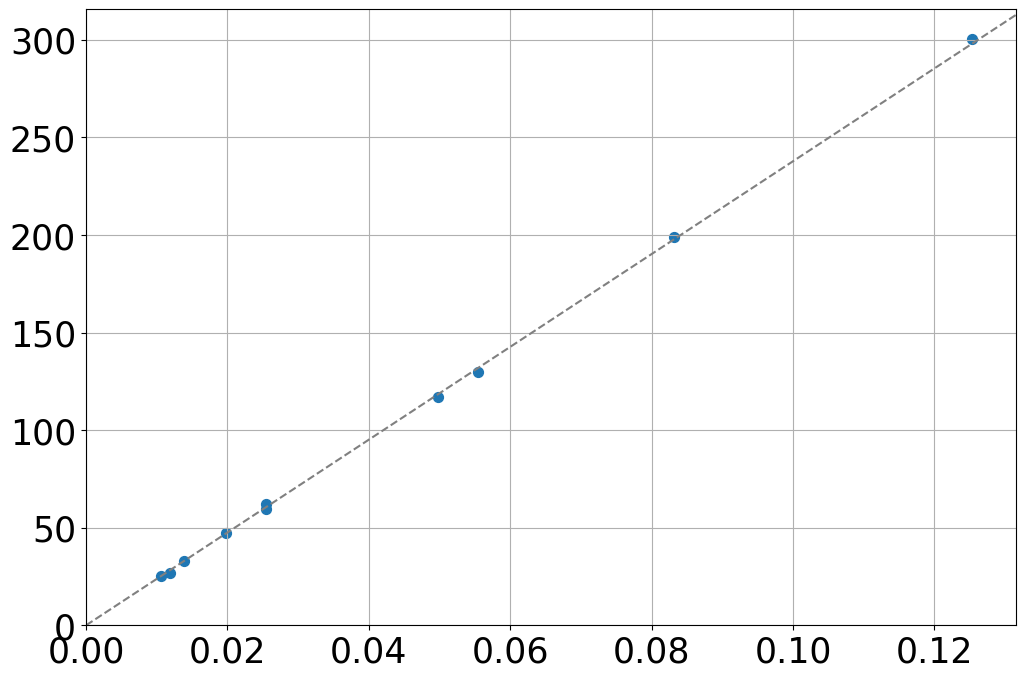

In [5]:

vars = torch.var(u_sym,dim = 1).cpu().numpy()
MCs = torch.sum(mfs[:,:1200],dim=1).cpu().numpy()
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots(figsize=(12,8))
plt.axline((0,0),(np.sum(vars),np.sum(MCs)),c="grey",linestyle="--")
#plt.plot(vars,MCs,"bo--")
plt.scatter(vars,MCs,s=50)

plt.grid(True)
plt.xlim(0,np.max(vars)*1.05)
plt.ylim(0,np.max(MCs)*1.05)
#plt.xlabel(r"$\sigma^2 (u_{k}(t))$")
#plt.ylabel(r"$MC^(k)$")
print(vars)
print(MCs)

[0.12529139 0.083125   0.05545869 0.01972884 0.0498294  0.02548799
 0.01053772 0.02546923 0.01380205 0.01192176]
[300.58334416 198.85679826 129.57190438  47.48906402 116.81885311
  61.92253181  25.41525451  59.54127345  33.09151987  26.83609207]


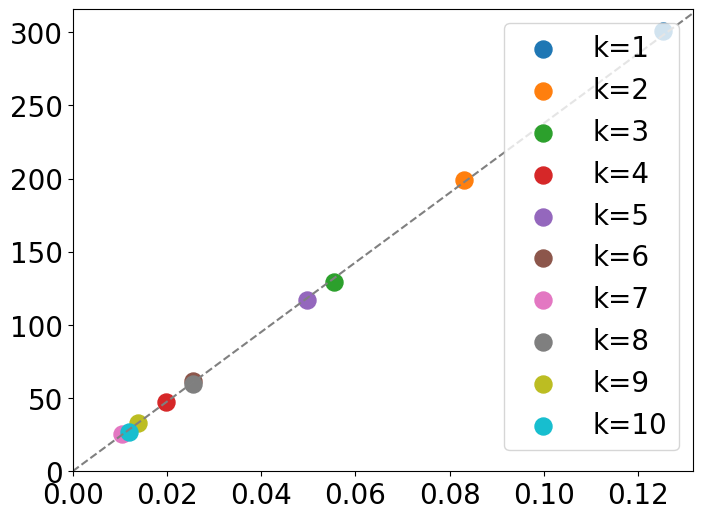

In [10]:

plt.rcParams.update({'font.size': 20})

fig,ax = plt.subplots(figsize=(8,6))

plt.axline((0,0),(np.sum(vars),np.sum(MCs)),c="grey",linestyle="--")
#plt.plot(vars,MCs,"bo--")

labels = ["dim "+str(d+1) for d in range(dim)]
labels = ["k="+str(d+1) for d in range(dim)]

for d in range(dim):
    #plt.scatter(vars[d],MCs[d],s=100,label=labels[d])
    plt.scatter(vars[d],MCs[d],s=150,label=labels[d])
    
plt.legend()
    
#plt.grid(True)
plt.xlim(0,np.max(vars)*1.05)
plt.ylim(0,np.max(MCs)*1.05)
#plt.xlabel(r"$\sigma^2 (u_{k}(t))$")
#plt.ylabel(r"$MC^(k)$")
print(vars)
print(MCs)
fig.savefig("idwin_beta.svg")

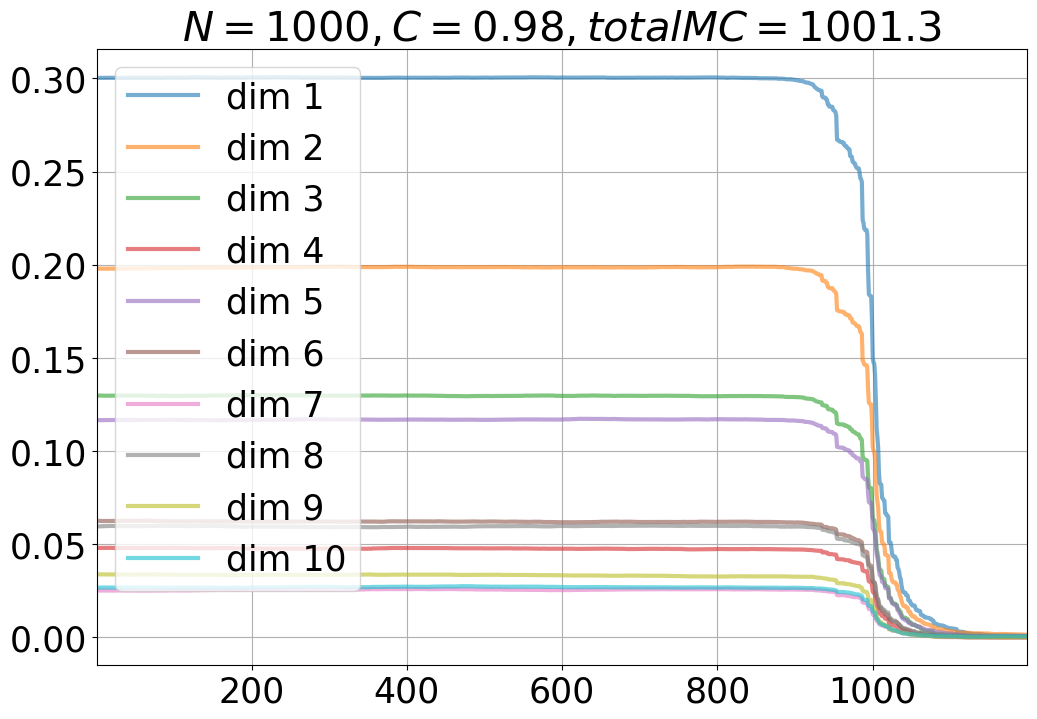

In [98]:
# plot forgetting curve
#maxtau = 1300
fig,ax = plt.subplots(figsize=(12,8))
taus = np.arange(1,maxtau)
for d in range(dim):
    plt.plot(taus,mfs[d][:taus.shape[0]].cpu().numpy(),alpha=0.6,label="dim "+str(d+1),linewidth=3)
plt.xlim(1,taus.shape[0])

#plt.ylim(-0.1,1.1)
#plt.ylim(0,0.2)
"""
plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
"""
plt.title(r'$N=%d, C=%.2f, totalMC=%.1f$'%(N_d,C,totMC))

plt.legend().set_loc("upper left")
plt.grid(True)
plt.show()

torch.Size([6, 100, 1])
torch.Size([6, 100, 10])
torch.Size([10])
torch.Size([100, 10])


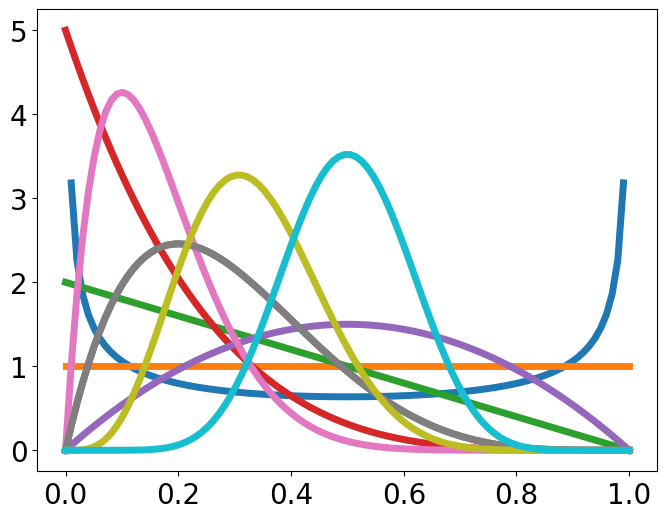

In [14]:

x = torch.linspace(0, 1, 100)
x_2d = torch.stack([x.unsqueeze(1)]* 6)
pdf_3d = torch.exp(m.log_prob(x_2d))
means = m.mean
pdfs = pdf_3d[0]

print(x_2d.shape)
print(pdf_3d.shape)
print(means.shape)
print(pdfs.shape)

plt.figure(figsize=(8,6))


plt.rcParams.update({'font.size': 20})
for i in range(alphas.shape[0]):
    # Compute the PDF for each x-value
    # Plot the PDF
    x_i = x 
    plt.plot(x_i.cpu().numpy(), pdfs[:,i].cpu().numpy(), label=f'({alphas[i]}, {betas[i]})',linewidth=5)
""" 
plt.title('Probability Distribution Function of Beta Distributions')
plt.xlabel('x')
plt.ylabel('PDF')
"""
#plt.legend().set_loc(1)

#plt.legend(title="(α,β)")
plt.show()

torch.Size([6, 100, 1])
torch.Size([6, 100, 10])
torch.Size([10])
torch.Size([100, 10])


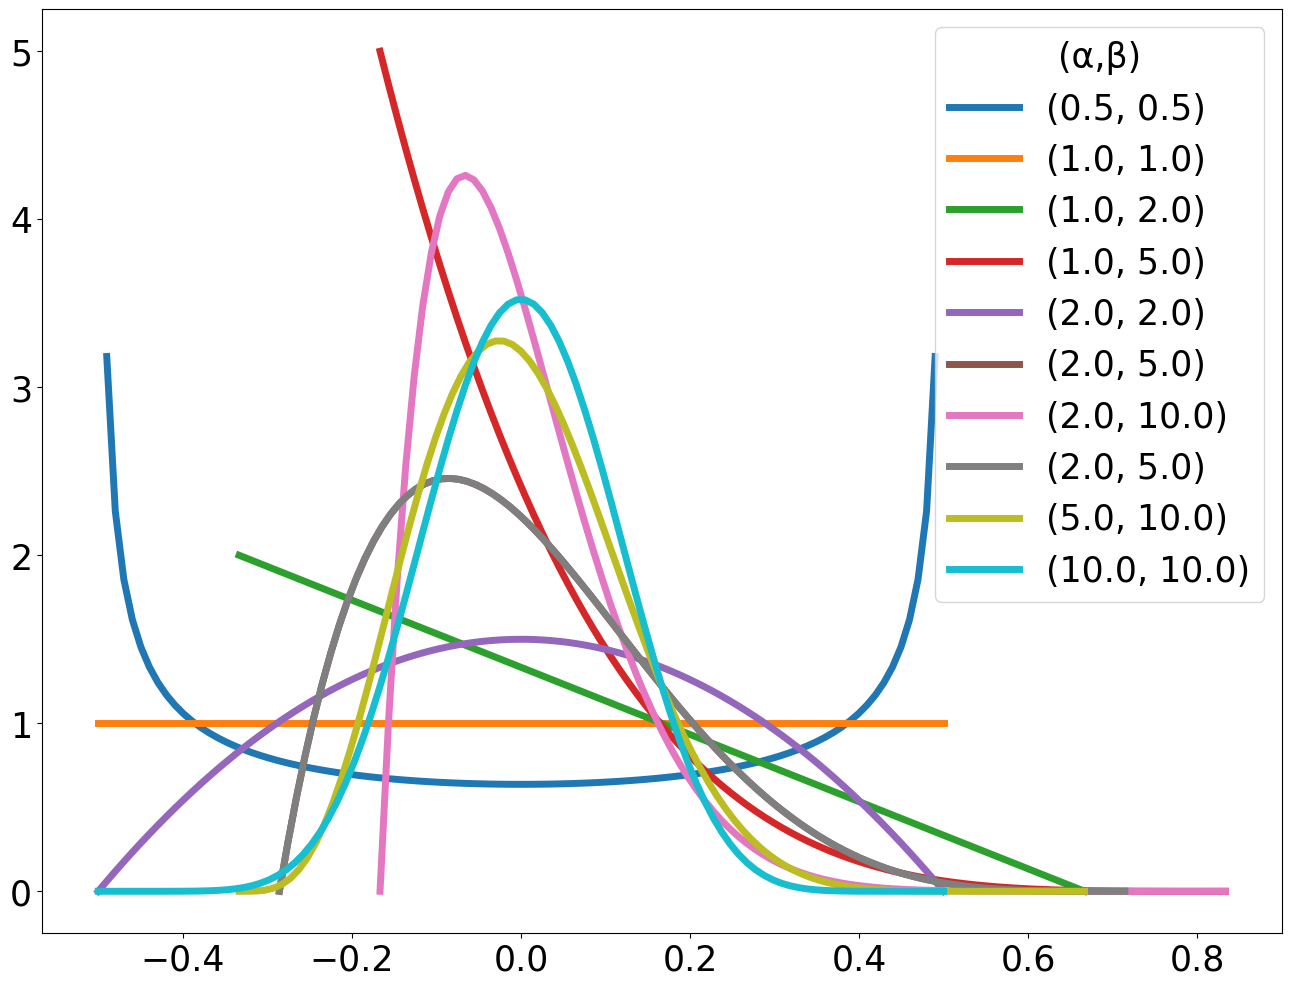

In [96]:
x = torch.linspace(0, 1, 100)
x_2d = torch.stack([x.unsqueeze(1)]* 6)
pdf_3d = torch.exp(m.log_prob(x_2d))
means = m.mean
pdfs = pdf_3d[0]

print(x_2d.shape)
print(pdf_3d.shape)
print(means.shape)
print(pdfs.shape)

plt.figure(figsize=(16,12))


plt.rcParams.update({'font.size': 25})
for i in range(alphas.shape[0]):
    # Compute the PDF for each x-value
    # Plot the PDF
    x_i = x - means[i]
    plt.plot(x_i.cpu().numpy(), pdfs[:,i].cpu().numpy(), label=f'({alphas[i]}, {betas[i]})',linewidth=5)
""" 
plt.title('Probability Distribution Function of Beta Distributions')
plt.xlabel('x')
plt.ylabel('PDF')
"""
plt.legend().set_loc(1)

plt.legend(title="(α,β)")
plt.show()